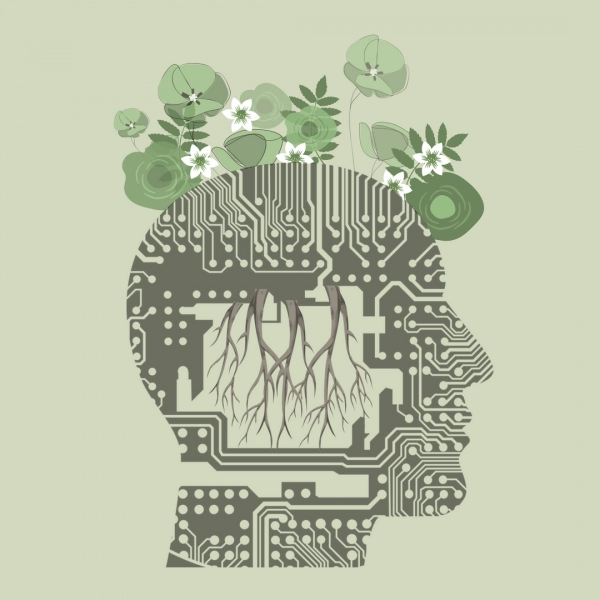

# **Health, Wealth and Green Space- a Study of the Effects of Health in England**


<font color=skyblue>Health</font> is important and at the forefront of many people's minds. This project looks at the effects that <font color=green>green space</font> and <font color=orange>wealth</font> has on health.


## Import Packages and Files




Import packages

In [45]:
import pandas as pd
from scipy.stats import zscore
import geopandas as gpd
%pip install mapclassify

import seaborn as sns
import mapclassify as mc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import matplotlib.cm as cm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np



Import the files to be used

These datasets came from various scources. The dataset scources can be found in the READ ME file

In [46]:
district = gpd.read_file("LAD_MAY_2022_UK_BFE_V3.shp")
health = pd.read_csv("TS037-2021-3.csv")
qualification = pd.read_csv("TS067-2021-3-filtered-2024-05-15T15_13_57Z.csv")
green = pd.read_csv("Census_ward_level_GLUD_tables.csv")
occupation = pd.read_csv("census2021-ts063-msoa.csv")
ea = pd.read_csv("census2021-ts066-msoa.csv")

## Pre-process all datasets





### Pre-process the district dataset

The shapefile will be used to map other datasets by Local Authority District (LAD) in the UK. Since the project focuses on England only, redundant rows for Wales ('W'), Scotland ('S'), and Northern Ireland ('N') were removed. These areas can be identified by their 'LAD22CD' column, where those in England start with 'E'. Dropping these rows is crucial to prevent NaN values during spatial joins with other datasets, ensuring smooth data mapping.

In [47]:
district.tail(1)

LAD22CD         LAD22NM   BNG_E   BNG_N     LONG      LAT  \
373  W06000024  Merthyr Tydfil  305916  206424 -3.36425  51.7486   

                                 GlobalID  \
373  0c604196-e06d-4644-8fa0-cf983deefc3f   

                                              geometry  
373  POLYGON ((303435.502 214925.598, 303431.602 21...

In [48]:
# Drop rows 309 to 374 as this includes the rest of the UK, outside of England
district = district.drop(district.index[309:375])
district.tail(1)

LAD22CD      LAD22NM   BNG_E   BNG_N     LONG      LAT  \
308  E09000033  Westminster  528268  180870 -0.15295  51.5122   

                                 GlobalID  \
308  a57e19ea-ccf8-4b29-8102-d3543f060abc   

                                              geometry  
308  POLYGON ((526735.197 183706.204, 526772.704 18...

Inconsistencies exist in geographic names across all datasets, despite representing the same units. In the district dataset, variations like 'Bristol' and 'Kingston Upon Hull' followed by ‘, City of’ were observed, while 'Herefordshire' was followed by ', County of'. This disparity wasn't consistent across other datasets.

In [49]:
# Replace ', City of' and ', County of' with an empty string, treating them as plain text.
# Here, the regex=False function specifies that it is a string as opposed to an expression, making the match more specified.
district['LAD22NM'] = district['LAD22NM'].str.replace(', City of', '', regex=False)
district['LAD22NM'] = district['LAD22NM'].str.replace(', County of', '', regex=False)



###<font color=green>Pre Process the green dataset<font>

Limited availability of open-source data led to the use of a 2015 dataset for <font color=green>'green'</font>, while other datasets were from 2021 and 2023 for districts. Over time, local authority districts underwent changes, such as mergers or name alterations. Therefore, they were changed to standardise across all datasets, allowing the joins to occur later.

In [50]:
green.head(1)

ONS_Code Census_Area_Statistics_(CAS)_Ward_Name LA_Code  \
0   00AAFA                             Aldersgate    00AA   

  Local_Authority_Name GOR_Code Government_Office_Region  \
0       City of London        H                   London   

   Area of Domestic Buildings  Area of Domestic Gardens  \
0                       11.25                      0.42   

   Area of Non Domestic Buildings  Area of Road  Area of Path  \
0                           55.15         32.05          0.88   

   Area of Greenspace  Area of Water  Areas of Other Land Uses  \
0                22.07             0                     16.28   

  Area of Unclassified Land  Total Area   Area of Admin Geography   \
0                         0       138.91                    129.87   

   Quality of Fit Indicator (%)  
0                          6.97

In [51]:
green['Local_Authority_Name'] = green['Local_Authority_Name'].replace(
    {'South Shropshire': 'Shropshire',
     'East Shropshire': 'Shropshire',
     'North Wiltshire': 'Wiltshire',
     'West Wiltshire': 'Wiltshire',
     'Bournemouth': 'Bournemouth, Christchurch and Poole',
     'Christchurch': 'Bournemouth, Christchurch and Poole',
     'Poole': 'Bournemouth, Christchurch and Poole',
     'East Dorset' : 'Dorset',
     'West Dorset' : 'Dorset',
     'North Dorset': 'Dorset',
     'West Somerset': 'Somerset West and Taunton',
     'Taunton Deane': 'Somerset West and Taunton',
     'Chester': 'Cheshire West and Chester',
     'Shepway': 'Folkestone and Hythe',
     'Congleton' : 'Cheshire East',
     'Macclesfield': 'Cheshire East',
     'Crewe and Nantwich': 'Cheshire East',
     'Wycombe' : 'Buckinghaamshire',
     'Aylesbury Vale': 'Buckinghamshire',
     'Chiltern': 'Buckinghamshire',
     'South Bucks': 'Buckinghamshire',
     'Durham': 'County Durham'})



The <font color=green>green</font> dataset includes two geographical units: census wards and local authority districts, resulting in multiple rows for one district. Since this study doesn't consider wards and associated columns, they were dropped. Many of these columns contained string data types, complicating potential merges later



In [52]:
# drop irrelevant data columns to allow merging to occur later
green = green.drop(columns=['ONS_Code', 'Census_Area_Statistics_(CAS)_Ward_Name', 'LA_Code', 'GOR_Code', 'Area of Domestic Buildings', 'Government_Office_Region','Area of Domestic Gardens', 'Area of Non Domestic Buildings','Area of Road', 'Area of Path', 'Area of Water', 'Areas of Other Land Uses', 'Area of Unclassified Land' ])

In this analysis, <font color=green>green</font> areas smaller than 5m² were excluded as they were considered too insignificant to impact health meaningfully. Mitchell and Popham (2008) adopted a similar approach in their study on the effects of <font color=green>green</font> space on <font color=orange>health</font> inequalities.

In [53]:
green = green[green['Area of Greenspace '] >= 5]

Before the rows are merged, a percentage of <font color=green>green space</font> is calculated out of the total area in each ward. This standardises the data points, allowing the data to be interpreted better.

In [54]:
# create a percent of green space to total area in each ward
green['Green Space %'] = (green['Area of Greenspace '] / green['Total Area '])*100

All ward rows are merged using the `groupby` function and calculated for the mean, resulting in a weighted average for each local district authority. Alternatively, an alternative method could first group the areas together and then calculate a simple arithmetic mean. However, the current method uses a weighted average, giving larger wards greater importance based on their size. This ensures a more representative average, as suggested by Ruhkin and Vangel (1998).




In [55]:
green = green.groupby('Local_Authority_Name').mean().reset_index()
green.head()

Local_Authority_Name  Area of Greenspace    Total Area   \
0                 Adur          2065.220714   3067.058571   
1            Allerdale         38317.366129  41834.363548   
2              Alnwick         65685.577500  67585.162500   
3         Amber Valley          9904.215652  11544.898696   
4                 Arun          6910.579615   8612.430769   

   Area of Admin Geography   Quality of Fit Indicator (%)  Green Space %  
0               3111.280714                     -2.744286      45.135567  
1              42567.322581                     -1.873871      80.658086  
2              67931.500000                     -2.178125      82.898515  
3              11538.538261                      0.005652      69.949199  
4               8757.612692                     -4.286154      48.256947

###<font color=skyblue>Pre Process the health dataset

In [56]:
health.head(6)

Lower tier local authorities Code Lower tier local authorities  \
0                         E06000001                   Hartlepool   
1                         E06000001                   Hartlepool   
2                         E06000001                   Hartlepool   
3                         E06000001                   Hartlepool   
4                         E06000001                   Hartlepool   
5                         E06000001                   Hartlepool   

   General health (6 categories) Code General health (6 categories)  \
0                                  -8                Does not apply   
1                                   1              Very good health   
2                                   2                   Good health   
3                                   3                   Fair health   
4                                   4                    Bad health   
5                                   5               Very bad health   

   Observation  
0            0  
1        39817  
2        30749  
3        14415  
4         5625  
5         1732

The dataset format is unusual as <font color=skyblue>health</font> is categorised into 6 levels displayed in rows for each area. Initially, categories representing good <font color=skyblue>health</font> were selected. A new dataframe was then created to extract these values, merged back into the <font color=skyblue>health</font> dataframe, and renamed 'Good Health Observations' for clarity. Subsequently, a weighted average was calculated by totalling these values and merging them. Unnecessary columns were dropped to facilitate this process.

In [57]:
# Selct the catagories of health that are high
good_health_conditions = health['General health (6 categories)'].isin(['Good health', 'Very good health'])

# Group by 'Lower tier local authorities' and sum up the 'Observation' column for rows meeting the conditions
good_health_sum = health.loc[good_health_conditions].groupby('Lower tier local authorities')['Observation'].sum()

# Merge the sum back into the original DataFrame based on 'Lower tier local authorities'
health = health.merge(good_health_sum, how='left', on='Lower tier local authorities', suffixes=('', '_sum'))

# Rename the new column
health.rename(columns={'Observation_sum': 'Good Health Observation'}, inplace=True)

# Create a total
health['Total'] = health.groupby('Lower tier local authorities')['Observation'].transform('sum')

# Create a percent
health['Good or Great Health %'] = (health['Good Health Observation'] / health['Total'])*100

# drop unnecessary columns that will intervine when grouping
health = health.drop(columns=['General health (6 categories) Code','General health (6 categories)', 'Observation', 'Lower tier local authorities Code'])

# Group by local authority
health = health.groupby('Lower tier local authorities').mean().reset_index()

health.head()

Lower tier local authorities  Good Health Observation     Total  \
0                         Adur                  51845.0   64544.0   
1                    Allerdale                  76028.0   96154.0   
2                 Amber Valley                 100805.0  126208.0   
3                         Arun                 131518.0  164889.0   
4                     Ashfield                  97432.0  126300.0   

   Good or Great Health %  
0               80.325050  
1               79.068993  
2               79.872116  
3               79.761537  
4               77.143310

###<font color=orange>Pre Process the economic activity (ea) dataset


The <font color=orange>economic activity</font> dataset includes codes for each local authority district, which differentiate between different wards. However, these codes add confusion and prevent grouping. Therefore, code was developed to remove the last 3 characters from each row in this column.


In [58]:
ea

date                 geography geography code  \
0     2021        City of London 001      E02000001   
1     2021  Barking and Dagenham 001      E02000002   
2     2021  Barking and Dagenham 002      E02000003   
3     2021  Barking and Dagenham 003      E02000004   
4     2021  Barking and Dagenham 004      E02000005   
...    ...                       ...            ...   
7259  2021               Wrexham 021      W02000424   
7260  2021               Wrexham 022      W02000425   
7261  2021               Wrexham 023      W02000426   
7262  2021     Neath Port Talbot 021      W02000427   
7263  2021               Swansea 032      W02000428   

      Economic activity status: Total: All usual residents aged 16 years and over  \
0                                                  8004                             
1                                                  5985                             
2                                                  8844                             
3                                                  5315                             
4                                                  7987                             
...                                                 ...                             
7259                                               5760                             
7260                                               7177                             
7261                                               8203                             
7262                                               9145                             
7263                                               8937                             

      Economic activity status: Economically active (excluding full-time students)  \
0                                                  5555                              
1                                                  3391                              
2                                                  5349                              
3                                                  3246                              
4                                                  5043                              
...                                                 ...                              
7259                                               3077                              
7260                                               3583                              
7261                                               4478                              
7262                                               4621                              
7263                                               4554                              

      Economic activity status: Economically active (excluding full-time students):In employment  \
0                                                  5273                                            
1                                                  3112                                            
2                                                  4965                                            
3                                                  3022                                            
4                                                  4720                                            
...                                                 ...                                            
7259                                               2999                                            
7260                                               3425                                            
7261                                               4307                                            
7262                                               4366                                            
7263                                               4404                                            

      Economic activity status: Economically active (excluding full-time students):In empl

In [59]:
# Get rid of unnecessary 3 letter code
ea['geography'] = ea['geography'].str.replace(r'\d{3}$', '', regex=True)


The 'geography code' column was dropped to facilitate grouping wards into local authority districts. Although other unnecessary columns remain in the dataframe, removing them was deemed unimportant and would lead to unnecessary code. However, to enable merging, certain columns needed to be converted to floats.


In [60]:
# Drop the geography code column
ea.drop(columns=['geography code'], inplace=True)

In [61]:
# Turn columns into floats
ea['Economic activity status: Economically active (excluding full-time students)'] = ea['Economic activity status: Economically active (excluding full-time students)'].astype(float)
ea['Economic activity status: Economically inactive'] = ea['Economic activity status: Economically inactive'].astype(float)

In [62]:
# Create a total column
ea['Total'] = ea['Economic activity status: Economically active (excluding full-time students)'] + ea['Economic activity status: Economically inactive']

#Create a percentage
ea['Economically Active %'] = (ea['Economic activity status: Economically active (excluding full-time students)'] / ea['Total'] * 100).astype(float)

# Group by locatl authority distict
ea = ea.groupby('geography').mean().reset_index()
ea

geography    date  \
0            Adur   2021.0   
1       Allerdale   2021.0   
2    Amber Valley   2021.0   
3            Arun   2021.0   
4        Ashfield   2021.0   
..             ...     ...   
326       Wrexham   2021.0   
327      Wychavon   2021.0   
328          Wyre   2021.0   
329   Wyre Forest   2021.0   
330          York   2021.0   

     Economic activity status: Total: All usual residents aged 16 years and over  \
0                                          6618.500000                             
1                                          6709.750000                             
2                                          6566.062500                             
3                                          7345.526316                             
4                                          6428.437500                             
..                                                 ...                             
326                                        6126.500000                             
327                                        5826.947368                             
328                                        6739.285714                             
329                                        6040.071429                             
330                                        7170.125000                             

     Economic activity status: Economically active (excluding full-time students)  \
0                                          3810.750000                              
1                                          3758.750000                              
2                                          3821.875000                              
3                                          3915.684211                              
4                                          3751.812500                              
..                                                 ...                              
326                                        3484.777778                              
327                                        3399.684211                              
328                                        3474.214286                              
329                                        3359.642857                              
330                                        3891.541667                              

     Economic activity status: Economically active (excluding full-time students):In employment  \
0                                          3654.625000                                            
1                                          3625.833333                                            
2                                          3687.937500                                            
3                                          3753.368421                                            
4                                          3580.875000                                            
..                                                 ...                                            
326                                        3337.388889                                            
327                                        3288.526316                                            
328                                        3325.071429                                            
329                                        3208.000000                                            
330                                        3762.875000                                            

     Economic activity status: Economically active (excluding full-time students):In employment:Employee  \
0                                          2901.125000                                                     
1                                          3018.416667                                                     
2                                          3138.062500                                                   

###<font color=orange>Pre process the occupation dataset

Similar to the <font color=skyblue>health</font> data set, there are 3 character codes tin the 'geography' column. These need to be deleted, as well as the 'geogeraphy code' column so that they can be grouped.

In [63]:
occupation

date                 geography geography code  \
0     2021        City of London 001      E02000001   
1     2021  Barking and Dagenham 001      E02000002   
2     2021  Barking and Dagenham 002      E02000003   
3     2021  Barking and Dagenham 003      E02000004   
4     2021  Barking and Dagenham 004      E02000005   
...    ...                       ...            ...   
7259  2021               Wrexham 021      W02000424   
7260  2021               Wrexham 022      W02000425   
7261  2021               Wrexham 023      W02000426   
7262  2021     Neath Port Talbot 021      W02000427   
7263  2021               Swansea 032      W02000428   

      Occupation (current): Total: All usual residents aged 16 years and over in employment the week before the census  \
0                                                  5346                                                                  
1                                                  3240                                                                  
2                                                  5238                                                                  
3                                                  3114                                                                  
4                                                  4864                                                                  
...                                                 ...                                                                  
7259                                               3103                                                                  
7260                                               3484                                                                  
7261                                               4417                                                                  
7262                                               4468                                                                  
7263                                               4575                                                                  

      Occupation (current): 1. Managers, directors and senior officials  \
0                                                  1104                   
1                                                   277                   
2                                                   512                   
3                                                   262                   
4                                                   432                   
...                                                 ...                   
7259                                                486                   
7260                                                583                   
7261                                                362                   
7262                                                349                   
7263                                                514                   

      Occupation (current): 2. Professional occupations  \
0                                                  2349   
1                                                   533   
2                                                   912   
3                                                   614   
4                                                   784   
...                                                 ...   
7259                                                709   
7260                                                764   
7261                                                734   
7262                                                602   
7263                                               1165   

      Occupation (current): 3. Associate professional and technical occupations  \
0                                                  1027                           
1                                                   308                           
2                    

In [64]:
occupation['geography'] = occupation['geography'].str.replace(r'\d{3}$', '', regex=True)
occupation = occupation.drop(columns=['geography code'])
occupation.head()

date              geography  \
0  2021        City of London    
1  2021  Barking and Dagenham    
2  2021  Barking and Dagenham    
3  2021  Barking and Dagenham    
4  2021  Barking and Dagenham    

   Occupation (current): Total: All usual residents aged 16 years and over in employment the week before the census  \
0                                               5346                                                                  
1                                               3240                                                                  
2                                               5238                                                                  
3                                               3114                                                                  
4                                               4864                                                                  

   Occupation (current): 1. Managers, directors and senior officials  \
0                                               1104                   
1                                                277                   
2                                                512                   
3                                                262                   
4                                                432                   

   Occupation (current): 2. Professional occupations  \
0                                               2349   
1                                                533   
2                                                912   
3                                                614   
4                                                784   

   Occupation (current): 3. Associate professional and technical occupations  \
0                                               1027                           
1                                                308                           
2                                                539                           
3                                                350                           
4                                                509                           

   Occupation (current): 4. Administrative and secretarial occupations  \
0                                                267                     
1                                                298                     
2                                                567                     
3                                                343                     
4                                                467                     

   Occupation (current): 5. Skilled trades occupations  \
0                                                 97     
1                                                414     
2                                                580     
3                                                390     
4                                                558     

   Occupation (current): 6. Caring, leisure and other service occupations  \
0                                                152                        
1                                                378                        
2                                                519                        
3                                                302                        
4                                                562                        

   Occupation (current): 7. Sales and customer service occupations  \
0                                                122                 
1                                                254                 
2                                                427                 
3                                                216                 
4                                                434                 

   Occupation (current): 8. Process, plant and machine operatives  \
0                                                 50                
1               

<font color=orange>Highly skilled occupations</font> were aggregated, encompassing managerial roles to skilled trades such as CAD technician, land surveyor (using GIS), and registered nurse. These <font color=orange>occupations</font> typically require advanced education, suggesting higher earnings. The information was sourced from the nationalcareers.service.gov website. The dataset already included a total count of individuals per area, from which a percentage was derived.

In [65]:
# Select ooupations that are regarded as highly skilled
occupation['Highly Skilled'] = (occupation['Occupation (current): 1. Managers, directors and senior officials'] +
                                 occupation['Occupation (current): 2. Professional occupations'] +
                                 occupation['Occupation (current): 3. Associate professional and technical occupations'] +
                                 occupation['Occupation (current): 4. Administrative and secretarial occupations'] +
                                 occupation['Occupation (current): 5. Skilled trades occupations']).astype(float)

# Calculate the percentage of highly skilled workers
occupation['Highly Skilled %'] = (occupation['Highly Skilled'] / occupation['Occupation (current): Total: All usual residents aged 16 years and over in employment the week before the census']) * 100


# Group by 'geography' and calculate the mean
occupation = occupation.groupby('geography').mean().reset_index()

# Display the DataFrame
occupation

geography    date  \
0            Adur   2021.0   
1       Allerdale   2021.0   
2    Amber Valley   2021.0   
3            Arun   2021.0   
4        Ashfield   2021.0   
..             ...     ...   
326       Wrexham   2021.0   
327      Wychavon   2021.0   
328          Wyre   2021.0   
329   Wyre Forest   2021.0   
330          York   2021.0   

     Occupation (current): Total: All usual residents aged 16 years and over in employment the week before the census  \
0                                          3728.000000                                                                  
1                                          3686.750000                                                                  
2                                          3760.250000                                                                  
3                                          3852.842105                                                                  
4                                          3651.437500                                                                  
..                                                 ...                                                                  
326                                        3433.888889                                                                  
327                                        3351.052632                                                                  
328                                        3417.000000                                                                  
329                                        3270.714286                                                                  
330                                        4008.375000                                                                  

     Occupation (current): 1. Managers, directors and senior officials  \
0                                           466.875000                   
1                                           391.916667                   
2                                           477.187500                   
3                                           511.157895                   
4                                           352.750000                   
..                                                 ...                   
326                                         332.166667                   
327                                         542.263158                   
328                                         428.142857                   
329                                         416.428571                   
330                                         483.375000                   

     Occupation (current): 2. Professional occupations  \
0                                           668.125000   
1                                           584.250000   
2                                           650.062500   
3                                           554.315789   
4                                           508.000000   
..                                                 ...   
326                                         540.222222   
327                                         602.263158   
328                                         613.142857   
329                                         505.214286   
330                                         977.541667   

     Occupation (current): 3. Associate professional and technical occupations  \
0                                           527.000000                           
1                                           393.416667                           
2                                           464.875000                           
3                                           449.789474                           
4                                           401.062500                           
..                                                 ...                           
326                                

###<font color=orange>Pre process the qualification dataset

Similar to the <font color=skyblue>health</font> dataset, the <font color=orange>qualification</font> dataset is awkwardly formatted. Hence, a similar process was used to extract the required data. It should be noted that only the highest level of <font color=orange>qualification</font> (university degree or equivalent, and above) was considered, as most individuals attain A Levels or equivalent <font color=orange>qualifications</font>.

In [66]:
qualification.head(7)

Lower tier local authorities Code Lower tier local authorities  \
0                         E06000001                   Hartlepool   
1                         E06000001                   Hartlepool   
2                         E06000001                   Hartlepool   
3                         E06000001                   Hartlepool   
4                         E06000001                   Hartlepool   
5                         E06000001                   Hartlepool   
6                         E06000001                   Hartlepool   

   Highest level of qualification (8 categories) Code  \
0                                                 -8    
1                                                  0    
2                                                  1    
3                                                  2    
4                                                  3    
5                                                  4    
6                                                  5    

       Highest level of qualification (8 categories)  Observation  
0                                     Does not apply        17652  
1                                  No qualifications        17286  
2  Level 1 and entry level qualifications: 1 to 4...         7076  
3  Level 2 qualifications: 5 or more GCSEs (A* to...        10963  
4                                     Apprenticeship         5205  
5  Level 3 qualifications: 2 or more A levels or ...        13776  
6  Level 4 qualifications or above: degree (BA, B...        18526

In [67]:
# Filter rows where 'Highest level of qualification (8 categories) Code' is 6
high_qualification_conditions = qualification[qualification['Highest level of qualification (8 categories) Code'] == 5]

# Group by 'Lower tier local authorities' and sum up the 'Observation' column for rows meeting the conditions
high_qualification_sum = high_qualification_conditions.groupby('Lower tier local authorities')['Observation'].sum().reset_index()

# Merge the sum back into the original DataFrame based on 'Lower tier local authorities'
qualification = qualification.merge(high_qualification_sum, how='left', on='Lower tier local authorities', suffixes=('', '_sum'))

# Rename the new column
qualification.rename(columns={'Observation_sum': 'High Qualifications'}, inplace=True)

# Calculate the total number of qualifications for each 'Lower tier local authorities'
qualification['Total'] = qualification.groupby('Lower tier local authorities')['Observation'].transform('sum')

# Calculate the percentage of high qualifications
qualification['High Qualification %'] = (qualification['High Qualifications'] / qualification['Total']) * 100

# Drop unnecessary columns
qualification = qualification.drop(columns=['Highest level of qualification (8 categories) Code', 'Highest level of qualification (8 categories)', 'Lower tier local authorities Code', 'Observation'])

# Group by 'Lower tier local authorities' and calculate the mean
qualification = qualification.groupby('Lower tier local authorities').mean().reset_index()

qualification

Lower tier local authorities  High Qualifications     Total  \
0                           Adur              14784.0   64542.0   
1                      Allerdale              22855.0   96154.0   
2                   Amber Valley              30265.0  126203.0   
3                           Arun              36839.0  164887.0   
4                       Ashfield              22185.0  126301.0   
..                           ...                  ...       ...   
326                      Wrexham              32037.0  135118.0   
327                     Wychavon              36591.0  132492.0   
328                         Wyre              26682.0  111946.0   
329                  Wyre Forest              22057.0  101607.0   
330                         York              66749.0  202821.0   

     High Qualification %  
0               22.906015  
1               23.769162  
2               23.981205  
3               22.341968  
4               17.565182  
..                    ...  
326             23.710386  
327             27.617517  
328             23.834706  
329             21.708150  
330             32.910300  

[331 rows x 4 columns]

### <font color=orange>Create Z scores

A <font color=orange>wealth</font> index offers numerous benefits for summarising economic disparities across regions or groups. It simplifies complex information into a single, easily understandable figure, enabling quick comparisons or across areas.

<font color=orange>Highest qualification</font> attained is a crucial factor, as education strongly influences income potential and job opportunities. Regions with higher educational attainment tend to enjoy better economic prospects and incomes, increasing the wealth index's accuracy.

<font color=orange>Occupation</font> is vital in assessing wealth, as different job types offer varying income levels. High-paying, stable jobs significantly contribute to personal and regional wealth (Poirier et al., 2020)

<font color=orange>Economic activity</font> is important to consider  due to its direct correlation with overall economic prosperity. It is an indicator of a region's economic strength, reflecting employment levels, productivity, and job market health. Higher economic activity typically translates to increased income levels, improved living standards, and greater opportunities for wealth accumulation (Dasgupta et al., 2022).

The zscore package from the scipy.stats package was used to complete this analysis.


In [68]:
# create z score for ea
zscore_ea = ea.copy()
zscore_ea['Economically Active Z-Score'] = zscore(zscore_ea['Economically Active %'])
zscore_ea

geography    date  \
0            Adur   2021.0   
1       Allerdale   2021.0   
2    Amber Valley   2021.0   
3            Arun   2021.0   
4        Ashfield   2021.0   
..             ...     ...   
326       Wrexham   2021.0   
327      Wychavon   2021.0   
328          Wyre   2021.0   
329   Wyre Forest   2021.0   
330          York   2021.0   

     Economic activity status: Total: All usual residents aged 16 years and over  \
0                                          6618.500000                             
1                                          6709.750000                             
2                                          6566.062500                             
3                                          7345.526316                             
4                                          6428.437500                             
..                                                 ...                             
326                                        6126.500000                             
327                                        5826.947368                             
328                                        6739.285714                             
329                                        6040.071429                             
330                                        7170.125000                             

     Economic activity status: Economically active (excluding full-time students)  \
0                                          3810.750000                              
1                                          3758.750000                              
2                                          3821.875000                              
3                                          3915.684211                              
4                                          3751.812500                              
..                                                 ...                              
326                                        3484.777778                              
327                                        3399.684211                              
328                                        3474.214286                              
329                                        3359.642857                              
330                                        3891.541667                              

     Economic activity status: Economically active (excluding full-time students):In employment  \
0                                          3654.625000                                            
1                                          3625.833333                                            
2                                          3687.937500                                            
3                                          3753.368421                                            
4                                          3580.875000                                            
..                                                 ...                                            
326                                        3337.388889                                            
327                                        3288.526316                                            
328                                        3325.071429                                            
329                                        3208.000000                                            
330                                        3762.875000                                            

     Economic activity status: Economically active (excluding full-time students):In employment:Employee  \
0                                          2901.125000                                                     
1                                          3018.416667                                                     
2                                          3138.062500                                                   

In [69]:
# create z score for occupation
zscore_occupation = occupation.copy()
zscore_occupation['Highly Skilled Z-Score'] = zscore(zscore_occupation['Highly Skilled %'])
zscore_occupation

geography    date  \
0            Adur   2021.0   
1       Allerdale   2021.0   
2    Amber Valley   2021.0   
3            Arun   2021.0   
4        Ashfield   2021.0   
..             ...     ...   
326       Wrexham   2021.0   
327      Wychavon   2021.0   
328          Wyre   2021.0   
329   Wyre Forest   2021.0   
330          York   2021.0   

     Occupation (current): Total: All usual residents aged 16 years and over in employment the week before the census  \
0                                          3728.000000                                                                  
1                                          3686.750000                                                                  
2                                          3760.250000                                                                  
3                                          3852.842105                                                                  
4                                          3651.437500                                                                  
..                                                 ...                                                                  
326                                        3433.888889                                                                  
327                                        3351.052632                                                                  
328                                        3417.000000                                                                  
329                                        3270.714286                                                                  
330                                        4008.375000                                                                  

     Occupation (current): 1. Managers, directors and senior officials  \
0                                           466.875000                   
1                                           391.916667                   
2                                           477.187500                   
3                                           511.157895                   
4                                           352.750000                   
..                                                 ...                   
326                                         332.166667                   
327                                         542.263158                   
328                                         428.142857                   
329                                         416.428571                   
330                                         483.375000                   

     Occupation (current): 2. Professional occupations  \
0                                           668.125000   
1                                           584.250000   
2                                           650.062500   
3                                           554.315789   
4                                           508.000000   
..                                                 ...   
326                                         540.222222   
327                                         602.263158   
328                                         613.142857   
329                                         505.214286   
330                                         977.541667   

     Occupation (current): 3. Associate professional and technical occupations  \
0                                           527.000000                           
1                                           393.416667                           
2                                           464.875000                           
3                                           449.789474                           
4                                           401.062500                           
..                                                 ...                           
326                                

In [70]:
# create z score for highest qualification
zscore_qualification = qualification.copy()
zscore_qualification['High Qualification Z-Score'] = zscore(zscore_qualification['High Qualification %'])
zscore_qualification

Lower tier local authorities  High Qualifications     Total  \
0                           Adur              14784.0   64542.0   
1                      Allerdale              22855.0   96154.0   
2                   Amber Valley              30265.0  126203.0   
3                           Arun              36839.0  164887.0   
4                       Ashfield              22185.0  126301.0   
..                           ...                  ...       ...   
326                      Wrexham              32037.0  135118.0   
327                     Wychavon              36591.0  132492.0   
328                         Wyre              26682.0  111946.0   
329                  Wyre Forest              22057.0  101607.0   
330                         York              66749.0  202821.0   

     High Qualification %  High Qualification Z-Score  
0               22.906015                   -0.608787  
1               23.769162                   -0.488098  
2               23.981205                   -0.458449  
3               22.341968                   -0.687655  
4               17.565182                   -1.355571  
..                    ...                         ...  
326             23.710386                   -0.496316  
327             27.617517                    0.050000  
328             23.834706                   -0.478933  
329             21.708150                   -0.776279  
330             32.910300                    0.790064  

[331 rows x 5 columns]

In [71]:

# Sample data (replace with your actual data)
# zscore_qualification, zscore_occupation, zscore_ea are your actual dataframes

# Ensure 'geography' columns have the same dtype and no leading/trailing spaces
zscore_qualification.rename(columns={'Lower tier local authorities': 'geography'}, inplace=True)
zscore_qualification['geography'] = zscore_qualification['geography'].astype(str).str.strip()
zscore_occupation['geography'] = zscore_occupation['geography'].astype(str).str.strip()
zscore_ea['geography'] = zscore_ea['geography'].astype(str).str.strip()

# Extract the required columns from each DataFrame
zscore_qualification = zscore_qualification[['geography', 'High Qualification Z-Score']]
zscore_occupation = zscore_occupation[['geography', 'Highly Skilled Z-Score']]
zscore_ea = zscore_ea[['geography', 'Economically Active Z-Score']]

# Perform merges
wealth_variables = pd.merge(zscore_qualification, zscore_occupation, on='geography', how='outer')
wealth_variables = pd.merge(wealth_variables, zscore_ea, on='geography', how='outer')

# Display the final merged dataframe
wealth_variables.head()



geography  High Qualification Z-Score  Highly Skilled Z-Score  \
0          Adur                   -0.608787                0.131137   
1     Allerdale                   -0.488098               -0.668749   
2  Amber Valley                   -0.458449               -0.191448   
3          Arun                   -0.687655               -0.459955   
4      Ashfield                   -1.355571               -1.207475   

   Economically Active Z-Score  
0                    -0.306709  
1                    -0.686327  
2                    -0.175826  
3                    -1.318078  
4                    -0.210406

In [72]:
# rename columns so it is easier to merge
zscore_qualification.rename(columns={'Lower tier local authorities': 'geography'}, inplace=True)
zscore_qualification['geography'].astype(str)
# Extract the required columns from each DataFrame
zscore_qualification = zscore_qualification[['geography', 'High Qualification Z-Score']]
zscore_occupation = zscore_occupation[['geography', 'Highly Skilled Z-Score']]
zscore_ea = zscore_ea[['geography', 'Economically Active Z-Score']]

# Perform inner joins to merge the DataFrames based on the specified columns
wealth_variables = pd.merge(zscore_qualification, zscore_occupation, on='geography', how='right')
wealth_variables = pd.merge(wealth_variables, zscore_ea, on='geography', how='right')


wealth_variables


<ipython-input-72-644cbda94cc5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



geography  High Qualification Z-Score  Highly Skilled Z-Score  \
0            Adur                   -0.608787                0.131137   
1       Allerdale                   -0.488098               -0.668749   
2    Amber Valley                   -0.458449               -0.191448   
3            Arun                   -0.687655               -0.459955   
4        Ashfield                   -1.355571               -1.207475   
..            ...                         ...                     ...   
326       Wrexham                   -0.496316               -1.090600   
327      Wychavon                    0.050000                0.210361   
328          Wyre                   -0.478933                0.050603   
329   Wyre Forest                   -0.776279               -0.496487   
330          York                    0.790064                0.254766   

     Economically Active Z-Score  
0                      -0.306709  
1                      -0.686327  
2                      -0.175826  
3                      -1.318078  
4                      -0.210406  
..                           ...  
326                    -0.351596  
327                    -0.104722  
328                    -1.664457  
329                    -0.748729  
330                    -0.581588  

[331 rows x 4 columns]

In [73]:
# add the z-scores from the 3 varaibles together to create an index
wealth_variables['Wealth Index'] = wealth_variables['High Qualification Z-Score'] + wealth_variables['Highly Skilled Z-Score'] + wealth_variables['Economically Active Z-Score']
wealth_variables.head()


geography  High Qualification Z-Score  Highly Skilled Z-Score  \
0          Adur                   -0.608787                0.131137   
1     Allerdale                   -0.488098               -0.668749   
2  Amber Valley                   -0.458449               -0.191448   
3          Arun                   -0.687655               -0.459955   
4      Ashfield                   -1.355571               -1.207475   

   Economically Active Z-Score  Wealth Index  
0                    -0.306709     -0.784359  
1                    -0.686327     -1.843173  
2                    -0.175826     -0.825722  
3                    -1.318078     -2.465689  
4                    -0.210406     -2.773452

###Join all variables to shapefile

In [74]:
district.head(1)

LAD22CD     LAD22NM   BNG_E   BNG_N     LONG      LAT  \
0  E06000001  Hartlepool  447160  531474 -1.27018  54.6761   

                               GlobalID  \
0  2efc9848-300e-4ef3-a36e-58d6856b9817   

                                            geometry  
0  POLYGON ((447213.900 537036.104, 447228.798 53...

In [75]:
# merge green dataframe
green_geo= pd.merge(district, green, left_on='LAD22NM', right_on='Local_Authority_Name', how='left')
green_geo.head(1)

LAD22CD     LAD22NM   BNG_E   BNG_N     LONG      LAT  \
0  E06000001  Hartlepool  447160  531474 -1.27018  54.6761   

                               GlobalID  \
0  2efc9848-300e-4ef3-a36e-58d6856b9817   

                                            geometry Local_Authority_Name  \
0  POLYGON ((447213.900 537036.104, 447228.798 53...           Hartlepool   

   Area of Greenspace   Total Area   Area of Admin Geography   \
0          4282.488824  5643.924118               5790.328824   

   Quality of Fit Indicator (%)  Green Space %  
0                     -2.893529      44.447599

In [76]:
# merge health dataframe
health_geo = pd.merge(district, health, left_on='LAD22NM', right_on='Lower tier local authorities', how='left')
health_geo.head(1)

LAD22CD     LAD22NM   BNG_E   BNG_N     LONG      LAT  \
0  E06000001  Hartlepool  447160  531474 -1.27018  54.6761   

                               GlobalID  \
0  2efc9848-300e-4ef3-a36e-58d6856b9817   

                                            geometry  \
0  POLYGON ((447213.900 537036.104, 447228.798 53...   

  Lower tier local authorities  Good Health Observation    Total  \
0                   Hartlepool                  70566.0  92338.0   

   Good or Great Health %  
0               76.421408

In [77]:
# merge wealth dataframe
wealth_geo = pd.merge(district, wealth_variables, left_on='LAD22NM', right_on= 'geography', how='left')
wealth_geo.head(1)

LAD22CD     LAD22NM   BNG_E   BNG_N     LONG      LAT  \
0  E06000001  Hartlepool  447160  531474 -1.27018  54.6761   

                               GlobalID  \
0  2efc9848-300e-4ef3-a36e-58d6856b9817   

                                            geometry   geography  \
0  POLYGON ((447213.900 537036.104, 447228.798 53...  Hartlepool   

   High Qualification Z-Score  Highly Skilled Z-Score  \
0                   -1.006278                -1.39077   

   Economically Active Z-Score  Wealth Index  
0                    -1.500726     -3.897774

## Data Exploration

### Histograms

Histograms used in this preliminary visualisation. Histograms provide an effective visualization method for understanding the distribution of percentage metrics across different local authority districts. By grouping data into bins, histograms reveal the frequency of occurrences within specific ranges, aiding in the identification of patterns, trends, and outliers. Additionally, histograms facilitate comparison between different datasets, allowing for a straightforward interpretation of how these metrics vary.


The chosen figure size, (10, 12), ensures that the plots fit properly on the screen, providing enough space for each histogram to be clearly visible without overlapping. The colour 'skyblue' was used across all plots ensuring a consistent colour scheme. This means that each subplot is not subconsciously perceived as having a higher or lower value or significance than another plot, which can often happen when using a colour scheme (Crameri et al., 2020). To improve the readability of the plots, the top and right spines (borders) of each subplot are hidden using set_visible(False). This helps focus the viewer's attention on the data itself rather than the plot borders.


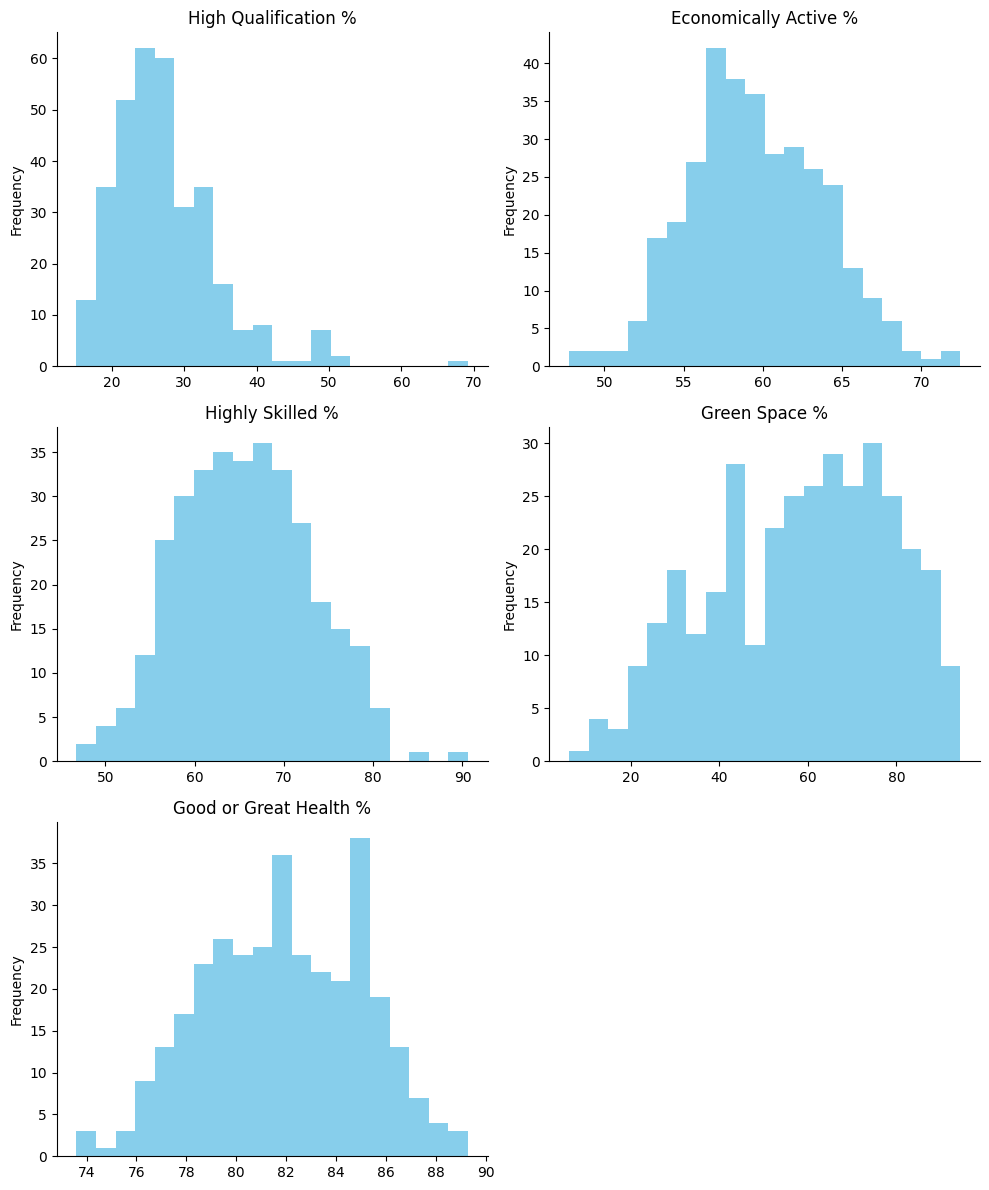

In [78]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12)) #this figure size was used as there would it did not fit the screen properly. maybe find a reference here for why certain things were used
axes = axes.flatten()

# Plot histograms on each subplot
qualification['High Qualification %'].plot(kind='hist', bins=20, ax=axes[0], title='High Qualification %', color='skyblue')
axes[0].spines[['top', 'right']].set_visible(False)

ea['Economically Active %'].plot(kind='hist', bins=20, ax=axes[1], title='Economically Active %', color='skyblue')
axes[1].spines[['top', 'right']].set_visible(False)

occupation['Highly Skilled %'].plot(kind='hist', bins=20, ax=axes[2], title='Highly Skilled %', color='skyblue')
axes[2].spines[['top', 'right']].set_visible(False)

green['Green Space %'].plot(kind='hist', bins=20, ax=axes[3], title='Green Space %', color='skyblue')
axes[3].spines[['top', 'right']].set_visible(False)

health['Good or Great Health %'].plot(kind='hist', bins=20, ax=axes[4], title='Good or Great Health %', color='skyblue')
axes[4].spines[['top', 'right']].set_visible(False)

# Hide the empty subplot
fig.delaxes(axes[5])

# Adjust layout
plt.tight_layout()
plt.show()

Histograms reveal significant variation across datasets. <font color=orange>Wealth</font> variables are unimodal, while <font color=green>'Green Space %'</font> and <font color=skyblue>'Good or Great Health %'</font> variables are bimodal or multimodal. <font color=skyblue>'Good or Great Health %'</font> data clusters between 74-89 and <font color=orange>qualifications</font> range from 15-68, indicating outliers affecting skewness and kurtosis. <font color=orange>'High Qualifications'</font> peak at 62, while other datasets peak around 30-40. Wealth data is more uniform compared to <font color=green>green space</font> and <font color=skyblue>health</font>, which show diverse regional conditions, highlighting disparities.

### Choropleth maps

In order to show the spatial distribution of all the variables, choropleth maps were made. Firstly, the 3 datasets were merged into 1, allowing for easy accsess in the code.

In [79]:
# merge all spatial dataframes together
merge1= pd.merge(green_geo, wealth_geo, left_on='LAD22NM', right_on='LAD22NM', how='right')
merge2= pd.merge(merge1, health_geo, left_on='LAD22NM', right_on='LAD22NM', how='right')
final_columns = ['LAD22NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID', 'geometry','Good or Great Health %', 'Wealth Index', 'Green Space %']
final = merge2[final_columns]


They were rounded the nearest 2 decimals to allow the values to sit better in the legend of the maps.

In [80]:
# Round the variable values to the 2 decimal places so that it displays better on the graph
final['Good or Great Health %'] = final['Good or Great Health %'].round(2)
final['Wealth Index'] = final['Wealth Index'].round(2)
final['Green Space %'] = final['Green Space %'].round(2)
final.head(1)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



LAD22NM   BNG_E   BNG_N     LONG      LAT  \
0  Hartlepool  447160  531474 -1.27018  54.6761   

                               GlobalID  \
0  2efc9848-300e-4ef3-a36e-58d6856b9817   

                                            geometry  Good or Great Health %  \
0  POLYGON ((447213.900 537036.104, 447228.798 53...                   76.42   

   Wealth Index  Green Space %  
0          -3.9          44.45

In [81]:
# Check that the crs is valid
final.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

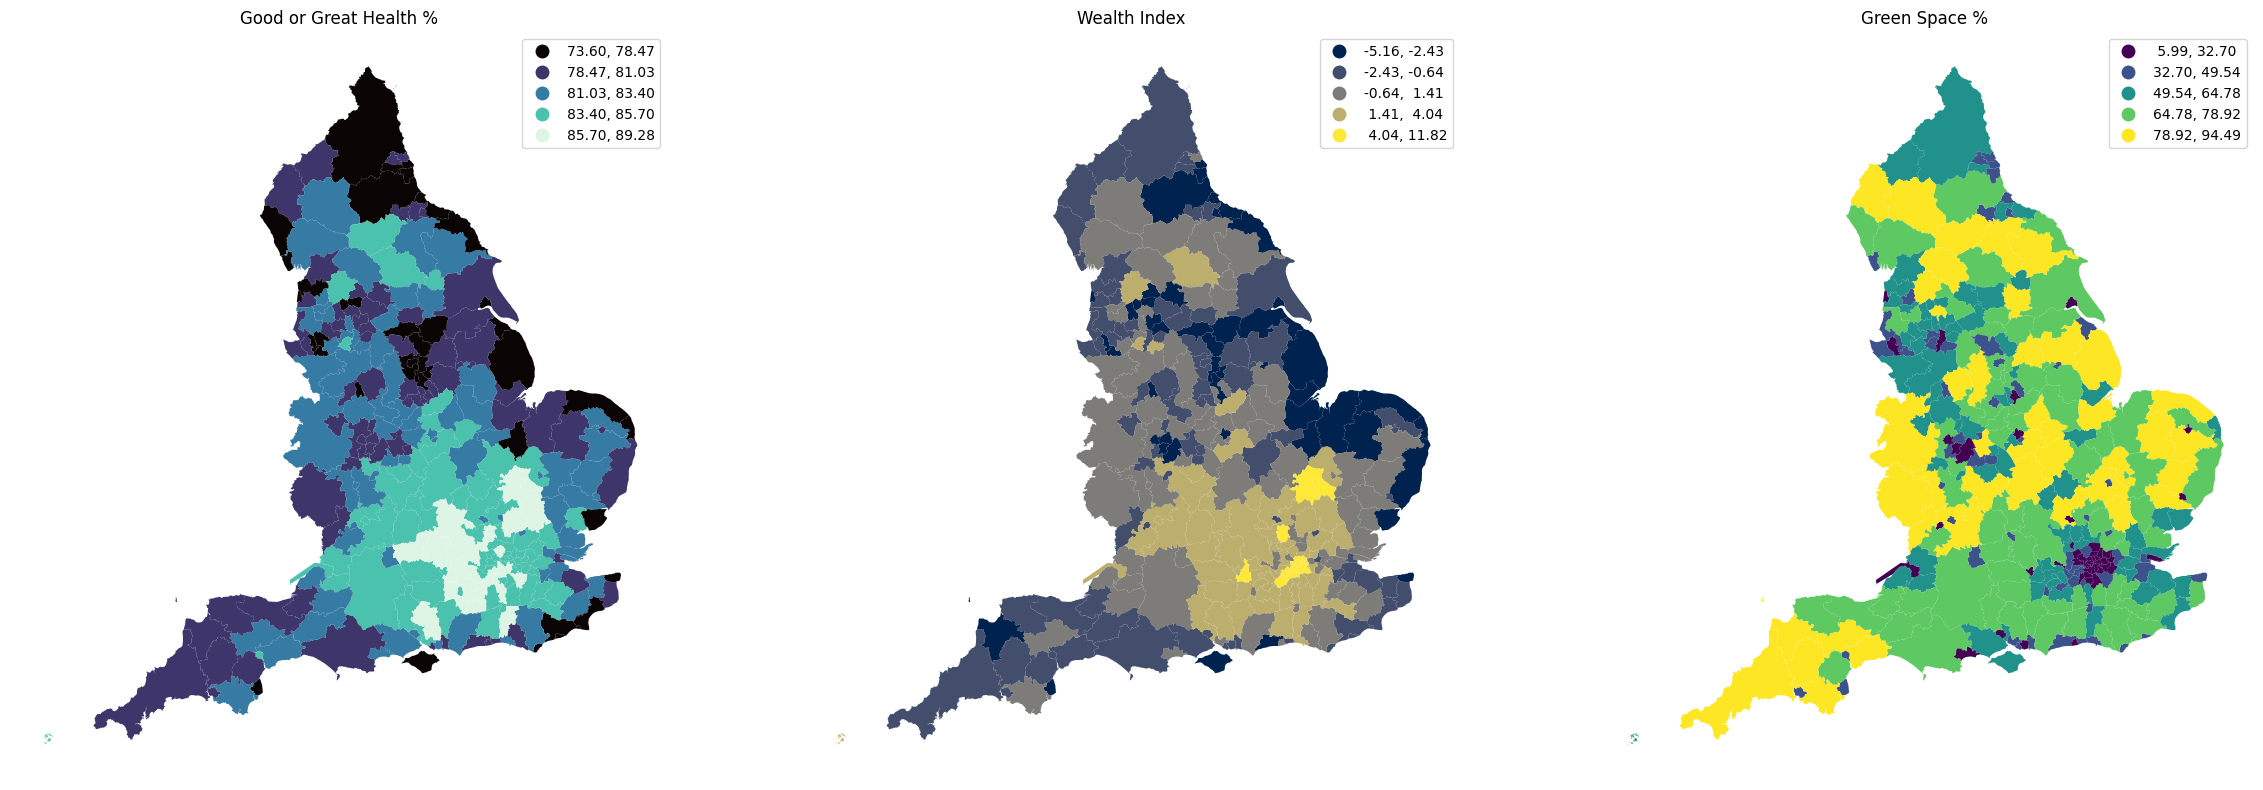

In [82]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot the first variable: Good or Great Health %
final.plot(column='Good or Great Health %', ax=axes[0], cmap='mako', legend=True, scheme='NaturalBreaks')
axes[0].set_title('Good or Great Health %')
axes[0].set_axis_off()

# Plot the second variable: Wealth Index
final.plot(column='Wealth Index', ax=axes[1], cmap='cividis', legend=True, scheme='NaturalBreaks')
axes[1].set_title('Wealth Index')
axes[1].set_axis_off()

# Plot the third variable: Green Space %
final.plot(column='Green Space %', ax=axes[2], cmap='viridis', legend=True, scheme='NaturalBreaks')
axes[2].set_title('Green Space %')
axes[2].set_axis_off()

# Display the figure
plt.tight_layout()
plt.show()

Sequential colour schemes were used. Sequential colour schemes are ideal for choropleth maps because they can represent the natural ordering of data, with a gradient from lighter to darker shades. This enhances clarity, interpretation, and accessibility for viewers, enabling them to discern spatial patterns and trends intuitively.These colours were selected to be colour blind friendly.

Natural breaks classification as it identifies natural groupings or breaks in the data distribution, allowing for a better understaing of the data.

This analysis shows that <font color=green>green</font> areas are lowest in urban areas, and <font color=orange>wealth</font> and <font color=skyblue>health</font> are lowest in coastal areas.

### OLS Regression

OLS (Ordinary Least Squares) regression was used in this project to show the relationship between <font color=skyblue>health</font> (dependent variables) and two predictor variables: <font color=orange>wealth</font> and <font color=green>green</font> space. OLS is a good method for estimating linear relationships, providing clear, interpretable coefficients that indicate the strength and direction of these associations (Craven and Islam, 2011). By minimisingg the sum of squared residuals, OLS ensures the best possible fit for the data, allowing the importance of wealth and green space in predicting health to be assessed. Additionally, OLS's ability to provide statistical significance and confidence intervals aids in validating the reliability of the findings.

In [83]:
# Prepare the independent variables (Wealth Index and Green Space %)
X = final[['Wealth Index', 'Green Space %']]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Prepare the dependent variable (Good or Great Health %)
y = final['Good or Great Health %']

# Fit the multiple regression model
model = sm.OLS(y, X).fit()


# Standardise the predictors and the response variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Fit the multiple regression model on the standardized data
model_scaled = sm.OLS(y_scaled, X_scaled).fit()

model_scaled.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning:

divide by zero encountered in scalar divide



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.797
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              602.7
Date:                Fri, 24 May 2024   Prob (F-statistic):                   4.96e-107
Time:                        11:21:21   Log-Likelihood:                         -192.08
No. Observations:                 309   AIC:                                      388.2
Df Residuals:                     307   BIC:                                      395.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        nan           0           0
x1             0.8992      0.026     34.361      0.000       0.848       0.951
x2             0.0390      0.026      1.492      0.137      -0.012       0.091
==============================================================================
Omnibus:                        8.789   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               10.430
Skew:                          -0.276   Prob(JB):                      0.00543
Kurtosis:                       3.711   Cond. No.                          inf
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Based on the regression results, <font color=orange>wealth</font> appears to be a more significant indicator of better <font color=skyblue>health</font> compared to <font color=green>green</font> space. This is clearly shown by the 0.8992 coeffecient value of wealth compared to 0.0390 of <font color=green>green</font> space.

## Interactive Scatter Plots- Non spatial visualisation

Scatter plots were created to show the correlation between all variables, individually. They provide a clear depiction of the data's distribution and any underlying patterns or trends. Scatterplots allow for easy identification of outliers and the overall spread of the data, aiding in understanding the strength and direction of the relationship between variables (Rensink and Baldridge, 2010)

The analysis used an interactive scatter plot generated using Plotly Express. Data points can be hovered over, revealing the locations attributed to the data point and the values associated with it. This package also allows the areas to be zoomed into to allow a better understanding of the data overall. The plotly method has been used recently to high succsess to illistrate various problems in an easy to understand way (Padney and Panchal, 2020;Dabbas, 2021; Kovapohia, 2022). This approach contrasts with static alternatives like Seaborn scatter plots, which requires manual labelling for each data point to its corresponding area. However, given the data's density, particularly in the <font color=skyblue>'Good or Great Health %</font> vs <font color=orange>Wealth Index'</font> subplot, using a method like this would result in label overlap, decreasing interpretability.

Adding a regression line to a plot has several benefits. Firstly, it visually illustrates trends in the data, indicating whether the relationship between variables is positive or negative. Secondly, it quantifies this relationship by estimating the line's slope and intercept through regression analysis. Moreover, comparing the regression line to actual data points helps assess the model's fit to the data, gauging how accurately it captures the relationship. Lastly, including a regression line aids in communicating results, providing a visual aid that enhances understanding and interpretation for others.

Blue was used for the data points, and red was used for the regression line. This colour scheme was used as it is colour blind friendly and they are different enough colours to make them both more visible. An opacity of 0.7 was added to accurately show each data point. This also shows the density of the data as darker areas will show data point overlap (Matejka et al., 2015).

This visualisation is directed to the public and policy makers. The ability to engage with the plot in a user friendly way means that a detailed understanding of how to interpret plots is not needed.



In [84]:
# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Good or Great Health % vs Green Space %", "Good or Great Health % vs Wealth Index"))

# Scatter plot for 'Good or Great Health %' vs 'Green Space %'
fig1 = px.scatter(final, x='Good or Great Health %', y='Green Space %', hover_name='LAD22NM', opacity=0.7, color_discrete_sequence=['blue'])
# Scatter plot for 'Good or Great Health %' vs 'Wealth Index'
fig2 = px.scatter(final, x='Good or Great Health %', y='Wealth Index', hover_name='LAD22NM', opacity=0.7, color_discrete_sequence=['blue'])
fig1.update_traces(marker={'size': 7})
fig2.update_traces(marker={'size': 7})
# Linear regression for 'Good or Great Health %' vs 'Green Space %'
x1 = final['Good or Great Health %'].values.reshape(-1, 1)
y1 = final['Green Space %'].values.reshape(-1, 1)
reg1 = LinearRegression().fit(x1, y1)
y1_pred = reg1.predict(x1)
r2_1 = r2_score(y1, y1_pred)

# Linear regression for 'Good or Great Health %' vs 'Wealth Index'
x2 = final['Good or Great Health %'].values.reshape(-1, 1)
y2 = final['Wealth Index'].values.reshape(-1, 1)
reg2 = LinearRegression().fit(x2, y2)
y2_pred = reg2.predict(x2)
r2_2 = r2_score(y2, y2_pred)

# Add scatter plots to subplots
fig.add_traces(fig1.data, rows=1, cols=1)
fig.add_traces(fig2.data, rows=1, cols=2)

# Add regression lines
fig.add_trace(go.Scatter(x=final['Good or Great Health %'], y=y1_pred.flatten(), mode='lines', name='Line of Best Fit', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=final['Good or Great Health %'], y=y2_pred.flatten(), mode='lines', name='Line of Best Fit', line=dict(color='red')), row=1, col=2)

# Add R-squared values as annotations
fig.add_annotation(x=77, y=20, xref="paper", yref="paper", text=f'R² = {r2_1:.2f}', showarrow=False, row=1, col=1)
fig.add_annotation(x=75, y=5, xref="paper", yref="paper", text=f'R² = {r2_2:.2f}', showarrow=False, row=1, col=2)

# Update layout for better spacing
fig.update_layout(title="Scatter Plots with R-squared Values", height=600, width=1200)

## Bivariate maps- spatial visulisation




3 quantiles were created to per variable and combined into new columns to show areas with varying amounts of <font color=skyblue>health</font> compared to <font color=green>green</font> space or <font color=orange>wealth</font>.

In [85]:
# create quantile
quantile= ['Low', 'Medium', 'High']
final[str("quantile"+ 'Green Space %')] = pd.qcut(final['Green Space %'], q=3, labels=quantile)
final[str("quantile"+ 'Wealth Index')] = pd.qcut(final['Wealth Index'], q=3, labels=quantile)
final[str("quantile"+ 'Good or Great Health %')] = pd.qcut(health_geo['Good or Great Health %'], q=3, labels=quantile)

# combine quantiles into new columns
final['Health and Green Space']= final[str("quantile" + 'Good or Great Health %')].astype(str) + " " + 'Health' + " / " + final[str("quantile" + 'Green Space %')].astype(str) + " " + 'Green'
final['Health and Wealth']= final[str("quantile" + 'Good or Great Health %')].astype(str) + " " + 'Health' + " / " + final[str("quantile" + 'Wealth Index')].astype(str) + " " + 'Wealth'
final.head()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

LAD22NM   BNG_E   BNG_N     LONG      LAT  \
0            Hartlepool  447160  531474 -1.27018  54.6761   
1         Middlesbrough  451141  516887 -1.21099  54.5447   
2  Redcar and Cleveland  464361  519597 -1.00608  54.5675   
3      Stockton-on-Tees  444940  518183 -1.30664  54.5569   
4            Darlington  428029  515648 -1.56835  54.5353   

                               GlobalID  \
0  2efc9848-300e-4ef3-a36e-58d6856b9817   
1  6d66b015-1f67-40f6-b239-15911fa03834   
2  a5a6513f-916e-4769-bed2-cd019d18719a   
3  14e8450b-7e7c-479a-a335-095ac2d9a701   
4  2f212ecf-daf5-4171-b9c6-825c0d33e5af   

                                            geometry  Good or Great Health %  \
0  POLYGON ((447213.900 537036.104, 447228.798 53...                   76.42   
1  POLYGON ((448489.897 522071.798, 448592.597 52...                   78.92   
2  POLYGON ((455525.931 528406.654, 455724.632 52...                   76.54   
3  POLYGON ((444157.002 527956.304, 444165.898 52...                   79.86   
4  POLYGON ((423496.602 524724.299, 423497.204 52...                   79.85   

   Wealth Index  Green Space % quantileGreen Space % quantileWealth Index  \
0         -3.90          44.45                   Low                  Low   
1         -4.23          42.59                   Low                  Low   
2         -4.12          61.95                Medium                  Low   
3         -1.74          50.93                Medium                  Low   
4         -1.63          45.14                   Low                  Low   

  quantileGood or Great Health %     Health and Green Space  \
0                            Low     Low Health / Low Green   
1                            Low     Low Health / Low Green   
2                            Low  Low Health / Medium Green   
3                            Low  Low Health / Medium Green   
4                            Low     Low Health / Low Green   

         Health and Wealth  
0  Low Health / Low Wealth  
1  Low Health / Low Wealth  
2  Low Health / Low Wealth  
3  Low Health / Low Wealth  
4  Low Health / Low Wealth

Each quantile combination was assigned a numeric value, allowing for it to be more easily interporated by pyhton.

In [86]:

# Mapping dictionary for Health and Green Space
health_green_mapping = {
    'Low Health / Low Green': 1,
    'Low Health / Medium Green': 2,
    'Low Health / High Green': 3,
    'Medium Health / Low Green': 4,
    'Medium Health / Medium Green': 5,
    'Medium Health / High Green': 6,
    'High Health / Low Green': 7,
    'High Health / Medium Green': 8,
    'High Health / High Green': 9
}

# Mapping dictionary for Health and Wealth
health_wealth_mapping = {
    'Low Health / Low Wealth': 1,
    'Low Health / Medium Wealth': 2,
    'Low Health / High Wealth': 3,
    'Medium Health / Low Wealth': 4,
    'Medium Health / Medium Wealth': 5,
    'Medium Health / High Wealth': 6,
    'High Health / Low Wealth': 7,
    'High Health / Medium Wealth': 8,
    'High Health / High Wealth': 9
}

# Apply mapping to create new columns
# This code was derived from chat gpt, with the prompt 'Given a DataFrame final with columns 'Health and Green Space' and 'Health and Wealth', and two dictionaries health_green_mapping and health_wealth_mapping that map category strings to numeric values, how can I create two new columns in the DataFrame that replace the category strings with the corresponding numeric values from the dictionaries?'
final['Health and Green Number'] = final['Health and Green Space'].apply(lambda x: health_green_mapping.get(x, None))
final['Health and Wealth Number'] = final['Health and Wealth'].apply(lambda x: health_wealth_mapping.get(x, None))
# .apply function creates a function
# The lambda function looks up the value x in the associated dictionary
# 'None' means that nothing is returned is no values are found

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



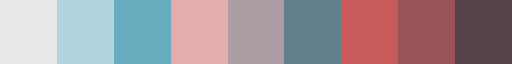

In [87]:
c_list= ['#e8e8e8','#b0d5df','#64acbe','#e4acac','#ad9ea5','#627f8c','#c85a5a','#985356','#574249']
cs = matplotlib.colors.ListedColormap(c_list)
cs

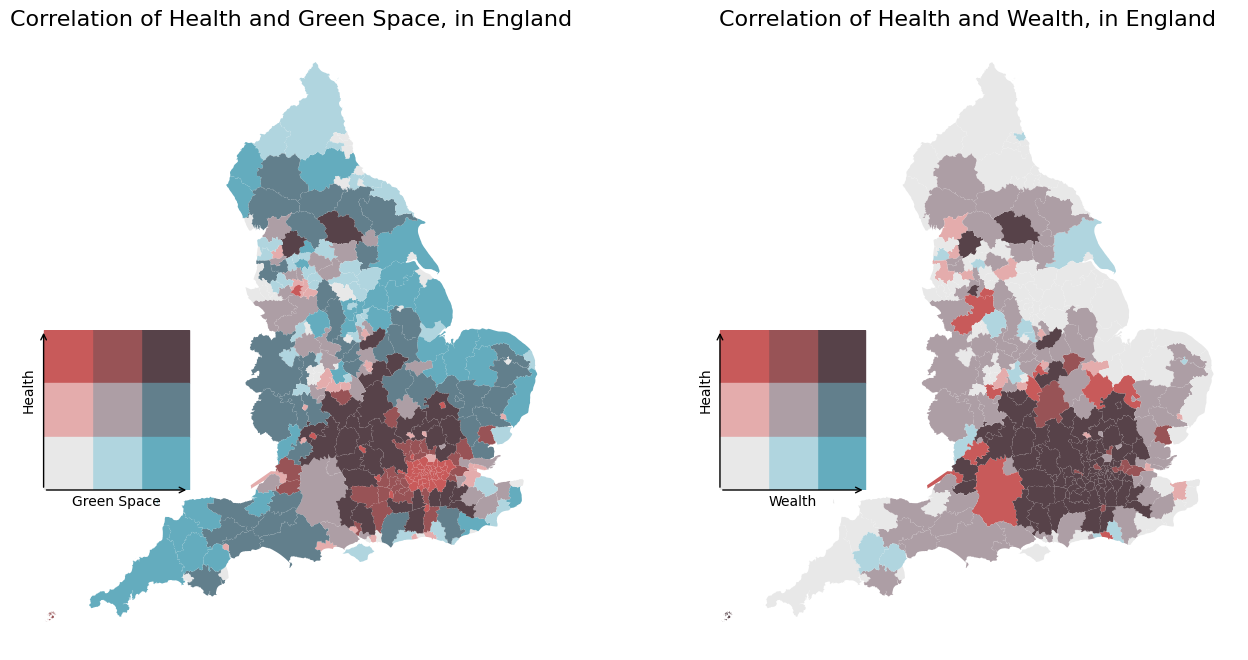

In [88]:
# Function to add a custom legend. This was created using chatGPT using the prompt, 'create a for loop of equally distanced squares to fit into a bivariate map legend, with consideration to the size of the plot.'
def add_custom_legend(ax, c_list, title1, title2): # using def, a definition block is started for a function
    # Create a new axes for the legend
    box_legend = ax.figure.add_axes(ax.get_position())
    # Set the position of the legend relative to the given axes
    box_legend.set_position([ax.get_position().x0 + 0.01, ax.get_position().y0 + 0.2, 0.1, 0.2])# postion it relative to x=0 and y=0

    # Define the size of each division
    division_size = 1 / 3 #specifies that for each line in the legend there are 3 divisons

    # Reverse the color list to mirror the legend
    c_list_reversed = c_list[::-1] # this is important as overwise the legend is mapped from top to bottom, creating an inaccurate map

    # Add mirrored legend squares
    for i, color in enumerate(c_list_reversed): # creates a loop which calculates the x and y indices for positioning the legend squares.
        # Calculate the x and y indices for positioning
        x_index = i % 3 #The x index is calculated by taking the remainder of dividing the loop index i by 3 using the modulo operator %. this creates the horizontal axes
        y_index = i // 3 #  the y index is obtained by performing integer division // on the loop index i by 3
        # Calculate the coordinates of the legend square
        xmin = 1 - (x_index + 1) * division_size
        ymin = 1 - (y_index + 1) * division_size
        xmax = xmin + division_size
        ymax = ymin + division_size
        # Add colour scheme to rectangles of the legend
        box_legend.axvspan(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, color=color)


    box_legend.axis('off')
    # Add arrows indicating the direction
    box_legend.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
    box_legend.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
    # Add text annotations for the legend titles
    box_legend.text(s=title1, x=-0.1, y=0.5, ha='center', rotation=90)
    box_legend.text(s=title2, x=0.5, y=-0.1, rotation=0, ha='center')

# Create a figure with two subplots
f, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first map
# Set the title for the first map
axes[0].set_title('Correlation of Health and Green Space, in England', fontsize=16)
# Plot the choropleth map for 'Health and Green Number' column using the custom legend
final.plot(column='Health and Green Number', ax=axes[0], cmap=cs, categorical=True, legend=False)
add_custom_legend(axes[0], c_list, 'Health', 'Green Space')

# Plot the second map
# Set the title for the second map
axes[1].set_title('Correlation of Health and Wealth, in England', fontsize=16)
# Plot the choropleth map for 'Health and Wealth Number' column using the custom legend
final.plot(column='Health and Wealth Number', ax=axes[1], cmap=cs, categorical=True, legend=False)
add_custom_legend(axes[1], c_list, 'Health', 'Wealth')

# Hide axes for both subplots
axes[0].set_axis_off()
axes[1].set_axis_off()

# Display the figure
plt.show()

Bivariate maps are an excellent visualisation tool as they allow for the simultaneous representation of two variables on a single map. This enables viewers to easily recognise patterns and relationships between the variables, providing a more comprehensive understanding of the data (Elmer, 2013). By using colour gradients, bivariate maps can effectively convey complex information, highlighting areas where the variables intersect and showing variations across the map (Trumbo, 1981). This makes them particularly useful for analysing spatial correlations and trends, offering a visually intuitive way to explore and communicate complex data.

The blue and orange colour scheme was chosen as it is colour-blind friendly, ensuring accessibility for all viewers. For the bivariate maps, three quantiles for each variable were used, which is standard practice in visualisation of bivariate maps. A for loop was created to make the code more efficient and less redundant; instead of manually specifying the position of each rectangle in the legend, the loop automatically places them correctly. Arrows were added to the plot to indicate the direction of higher values, making the visualisation easier to interpret. Additionally, the legend axes for <font color=skyblue>health</font> were rotated to enhance readability. This combination of techniques ensures that the maps are not only accessible to a wider audience but also visually informative and straightforward to understand. By implementing these thoughtful design choices, the visualisation effectively communicates the relationships between <font color=skyblue>health</font>, <font color=green>green space</font>, and <font color=orange>wealth</font>.

This map is designed for policymakers and academics to show where areas of high <font color=skyblue>health</font>, contrasted with <font color=green>green spaces</font> of <font color=skyblue>health</font>, and how strong of a correlation there is. For example, this will inform decisions to allocate or not allocate green space.

In both, of the maps, the highest correlation is located from the south to the midlands, in a similar circular formation.
A large proportion of the rest of the areas in the <font color=skyblue>health</font> and <font color=orange>wealth</font> are either white or grey, indicating a strong correlation between the 2 variables.
On the other hand in the <font color=skyblue>health</font> and <font color=green>green space</font> map, there are large areas of blue, indicating high <font color=green>green space</font> and lower <font color=skyblue>health</font>. Interestingly, the lowest <font color=skyblue>health</font> and highest <font color=green>green</font> space dynamic is found in coastal areas.


## Concluding Remarks

The results across all of the analysis show a high correlation between <font color=skyblue>health</font> and <font color=ornage>wealth</font> and a low correlation between <font color=skyblue>health</font> and <font color=green>green space</font>. This is contrary to most literature that concludes that <font color=green>green space</font> has a positive effect on <font color=skyblue>health</font>. For example, Mitchell and Popham (2008) <font color=green>greener</font> environments result in lower income deprivation-related <font color=skyblue>health</font> inequalities. However, the correaltion between <font color=orange>wealth</font> and <font color=skyblue>health</font> is suppoerted by literuature. For example, Pollack et al. (2007) reviewed literature on the topic and concluded that in most cases, higher <font color=orange>wealth</font> results in higher <font color=skyblue>health</font>  More research should be conducted into this field to validate these results.

# References

Crameri, F., Shephard, G.E. and Heron, P.J., 2020. The misuse of colour in science communication. Nature communications, 11(1), p.5444.
Craven, B.D. and Islam, S.M., 2011. Ordinary least-squares regression. The SAGE dictionary of quantitative management research, pp.224-228.

Dabbas, E., 2021. Interactive Dashboards and Data Apps with Plotly and Dash: Harness the power of a fully fledged frontend web framework in Python–no JavaScript required. Packt Publishing Ltd.

Dasgupta, P., Managi, S. and Kumar, P., 2022. The inclusive wealth index and sustainable development goals. Sustainability Science, 17(3), pp.899-903.
Elmer, M.E., 2013, August. Symbol considerations for bivariate thematic maps. In Proceedings of 26th International Cartographic Conference.

Kovapohja, F., 2022. Visualizing Changes over Time in Hierarchical Customer Data Using the Plotly Python Graphing Library (Doctoral dissertation, University of Helsinki).

Matejka, J., Anderson, F. and Fitzmaurice, G., 2015, April. Dynamic opacity optimization for scatter plots. In Proceedings of the 33rd Annual ACM Conference on Human Factors in Computing Systems (pp. 2707-2710).

Mitchell, R. and Popham, F., 2008. Effect of exposure to natural environment on health inequalities: an observational population study. The lancet, 372(9650), pp.1655-1660.

Pandey, K. and Panchal, R., 2020. A study of real world data visualization of COVID-19 dataset using Python. International Journal of Management and Humanities (IJMH), 4(8), pp.1-4.

Poirier, M.J., Grépin, K.A. and Grignon, M., 2020. Approaches and alternatives to the wealth index to measure socioeconomic status using survey data: a critical interpretive synthesis. Social Indicators Research, 148(1), pp.1-46.

Rensink, R.A. and Baldridge, G., 2010, June. The perception of correlation in scatterplots. In Computer graphics forum (Vol. 29, No. 3, pp. 1203-1210). Oxford, UK: Blackwell Publishing Ltd.

Rukhin, A.L. and Vangel, M.G., 1998. Estimation of a common mean and weighted means statistics. Journal of the American Statistical Association, 93(441), pp.303-308.

Trumbo, B.E., 1981. A theory for coloring bivariate statistical maps. The American Statistician, 35(4), pp.220-226.


word count for justification of process = 1498